### The libraries needed

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import chardet

Finding the encoding of the dataset

In [3]:

with open("dataset.csv", "rb") as f:
    result = chardet.detect(f.read(100000))  # Read a chunk of the file
    print(result["encoding"])  # Print the detected encoding


Windows-1252


Loading the dataset but only some of the columns we need 


In [4]:
df=pd.read_csv("dataset.csv", encoding="Windows-1252", sep=";",usecols=[0,1,2,5,6,7,10,11,14,17])
df.head(100)

,id,category,title,bathrooms,bedrooms,currency,pets_allowed,price,square_feet,state
0,5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,1.0,1.0,USD,Cats,2195.0,542,CA
1,5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,1.5,3.0,USD,"Cats,Dogs",1250.0,1500,VA
2,5668639686,housing/rent/apartment,Three BR 3101 Morningside Drive,2.0,3.0,USD,NaN,1395.0,1650,NC
3,5668639659,housing/rent/apartment,Two BR 209 Aegean Way,1.0,2.0,USD,"Cats,Dogs",1600.0,820,CA
4,5668639374,housing/rent/apartment,One BR 4805 Marquette NE,1.0,1.0,USD,"Cats,Dogs",975.0,624,NM
...,...,...,...,...,...,...,...,...,...,...
95,5668633801,housing/rent/apartment,Two BR 1917 S. 18th St.,1.0,2.0,USD,"Cats,Dogs",1015.0,845,NE
96,5668632658,housing/rent/apartment,Three BR 7312 South 81st Street,2.0,3.0,USD,"Cats,Dogs",1495.0,1850,NE
97,5668632537,housing/rent/apartment,One BR 4301 Grand Avenue Parkway,1.0,1.0,USD,NaN,1103.0,652,TX
98,5668632393,housing/rent/apartment,One BR 2101 W. ANDERSON LN.,1.0,1.0,USD,NaN,1032.0,600,TX


Lets drop the NaN values for the important variables

In [5]:
df = df.dropna(subset=["price"])

In [6]:
df["square_feet"].isna().value_counts()
#it doesnt have nan values so we will not perform anything

square_feet
False    99491
Name: count, dtype: int64

Since there are a lot of data i will use the data for 4 major states: New York, Texas, California and Florida. So i will filter those:

In [ ]:
df_ny=df[df["state"]=="NY"]#dataframe for new york
df_tx=df[df["state"]=="TX"]#Dataframe for Texas
df_ca=df[df["state"]=="CA"]#Dataframe for California
df_fl=df[df["state"]=="FL"]#Dataframe for Florida


,id,category,title,bathrooms,bedrooms,currency,pets_allowed,price,square_feet,state
30,5668630356,housing/rent/apartment,Two BR 4685 N. Haverhill Road,2.0,2.0,USD,"Cats,Dogs",1740.0,1600,FL
54,5668622445,housing/rent/apartment,One BR 5230 Eastwinds Dr,1.0,1.0,USD,"Cats,Dogs",973.0,509,FL
63,5668615006,housing/rent/apartment,Three BR 6465 Longleaf Branch Drive,2.0,3.0,USD,"Cats,Dogs",1499.0,1544,FL
69,5668610263,housing/rent/apartment,One BR 190 112th Ave N,1.0,1.0,USD,"Cats,Dogs",1055.0,550,FL
114,5668622224,housing/rent/apartment,One BR 2915 Sharer Road,1.0,1.0,USD,"Cats,Dogs",949.0,625,FL
...,...,...,...,...,...,...,...,...,...,...
99461,5121227895,housing/rent/apartment,One BR Apartment in Jacksonville,1.0,1.0,USD,NaN,1390.0,848,FL
99465,5121227292,housing/rent/apartment,Two BR - Wynnfield Lakes Apartments. Pet OK!,2.0,2.0,USD,"Cats,Dogs",1402.0,1245,FL
99470,5121226111,housing/rent/apartment,Convenient location One BR One BA for rent,1.0,1.0,USD,NaN,1550.0,942,FL
99486,5121221006,housing/rent/apartment,"Great Central Location One BR, One BA",1.0,1.0,USD,"Cats,Dogs",798.0,650,FL


### What I wanna do is make a linear regression where I take the square feet of the property as the independent variable and for the dependent variable to be the price for each of the states

Lets make the variables

In [7]:
#x will be the independent variable
x=df['square_feet'].values.tolist()
#y will be the dependent variable
y=df['price'].values.tolist()

Now creating the Linear regression stats

In [8]:
slope, intercept, r, p, std_err = stats.linregress(x, y)

The function of the Regression line will be:

In [9]:
def ref_func(x):
    return slope*x+intercept

In [10]:
mymodel=list(map(ref_func,x))

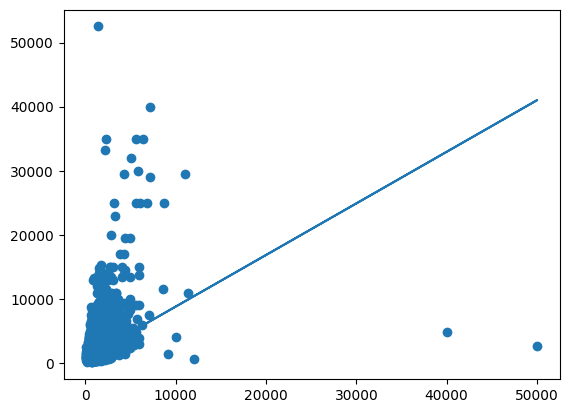

In [11]:
import matplotlib.pyplot as plt

plt.scatter(x=x,y=y)
plt.plot(x,mymodel)
plt.show()

In [12]:
p

np.float64(0.0)